In [ ]:
!pip install -q pyomo
!apt-get install -y -qq glpk-utils
from pyomo.environ import *
import itertools, random, math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# !apt-get install -y -qq coinor-cbc
# opt= SolverFactory('cbc', executable='/usr/bin/cbc')
# import os
# os.environ['NEOS_EMAIL'] = 'XXXXXX@gmail.com'
# from pyomo import environ as pe
# opt = pe.SolverManagerFactory('neos')

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 125081 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

In [ ]:
# ---------------------------
# simulation parameters
# ---------------------------
V = 2                   # number of vehicles
T = 20                 # discrete time horizon (t = 0..T)
delta_t = 1             # cycle length (s)
L = 20                 # route length (m)
lanes = 1               # number of lanes
Rg = 10                 # granularity for vehicles’ position measurement
P = [1,2]               # platforms
U = 2                   # number of platforms
K = 2                   # Loading/Unloading time = K * delta_t
rul = {1: [1, 1], 2: [5, 1]}#, 3: [7, 1]} # platform positions (discrete) all platforms are in lane 1

max_s_l = 0.25              # reduction in maximum speed per cargo unit (m/s)
max_s_ul = 4             # maximum number of steps delta_s for the speed. Max speed is given by max_s_ul * delta_s (m/s) - cargo units * max_s_l
delta_s = 0.4


# Speeds
S_vals = [round(i * delta_s, 2) for i in range(-int(max_s_ul), int(max_s_ul)+1, 1)]

max_speed = round(max_s_ul * delta_s, 2)
print(S_vals)
print(f"Maximum discrete jumps per second: {delta_t * max_speed / (L / Rg):2f}")

print(f"maximum speed with: ")
for u in range(1,U+1):
  print(f" {u} cargo: {max_s_ul * delta_s - u * max_s_l:2f} (m/s):")

[-1.6, -1.2, -0.8, -0.4, 0.0, 0.4, 0.8, 1.2, 1.6]
Maximum discrete jumps per second: 0.800000
maximum speed with: 
 1 cargo: 1.350000 (m/s):
 2 cargo: 1.100000 (m/s):


In [ ]:
# ---------------------------
#  Stochastic generation of cargo arrival (Poisson)
# ---------------------------
# random.seed(42)
# np.random.seed(42)

# average arrival rate (λ per cycle) for each platform
lambda_rate = {1: 2., 2: 1.5, 3: 1.3}

c_u_f_t = {}
for u in P:
    for t in range(T):
        arrivals = np.random.poisson(lambda_rate[u])
        c_u_f_t[(u,t)] = random.choice([x for x in P if x != u]) if arrivals >= 1 else 0

c_u_t_u = {}
for u in P:
    for t in range(T):
      for u2 in P:
        c_u_t_u[(u, t, u2)] = 1 if c_u_f_t[(u,t)] == u2 else 0

# print the arrivals map
print("Cargo arrival map (0=no cargo or destination):")
for u in P:
    row = [c_u_f_t[(u,t)] for t in range(10)]
    print(f"  Platforms {u}: {row}")

# Initial conditions (vehicle positions)
# Uniform generation between 0 and track_length
l0 = {v: random.randint(1,lanes) for v in range(1, V + 1)}
rvl = {v: [random.randint(1,Rg), l0[v]] for v in range(1, V + 1)}

print("Vehicls possition:")
for v in range(1,V+1):
    print(f"  Vehicle {v}: {rvl[(v)]}")

vLoad = {v: (1, random.choice(P)) if random.uniform(0,1)>0.5 else (0,0) for v in range(1,V+1)}

print("Vehicls cargo:")
for v in range(1,V+1):
    print(f"  Vehicle load {v}: {vLoad[(v)]}")

Cargo arrival map (0=no cargo or destination):
  Platforms 1: [2, 2, 2, 0, 2, 2, 2, 2, 2, 0]
  Platforms 2: [0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
Vehicls possition:
  Vehicle 1: [2, 1]
  Vehicle 2: [8, 1]
Vehicls cargo:
  Vehicle load 1: (0, 0)
  Vehicle load 2: (1, 1)


In [ ]:
# ---------------------------
# Pyomo Discrete Model
# ---------------------------
model = ConcreteModel()

# Sets
model.V = RangeSet(1, V)
model.Lanes = RangeSet(1, lanes)
model.T = RangeSet(0, T-1)
model.U = RangeSet(1, U)
model.R = RangeSet(1, Rg)
model.SpeedSet = Set(domain=Reals, initialize=S_vals)
model.SS = RangeSet(1, len(S_vals))
model.K = RangeSet(1, K)

# Build complete dictionary for Vehicle Param with values ​​0/1
rv = {}
lv = {}
for v in model.V:
    rv[(v)] = rvl[v][0]
    lv[(v)] = rvl[v][1]


# Construir dicionário completo para Platforms Param com valores 0/1
ru = {}
lu = {}
for u in model.U:
    ru[(u)] = rul[u][0]
    lu[(u)] = rul[u][1]

# Discrete system parameters
model.ru = Param(model.U, initialize=ru, domain=Integers)
model.lu = Param(model.U, initialize=lu, domain=Integers)
model.cu = Param(model.U, model.T, model.U, initialize=c_u_t_u, domain=Binary)
model.max_speed = Param(initialize=max_speed)
model.delta_t = Param(initialize=delta_t)
model.L = Param(initialize=L)

# Decision variables
model.p = Var(model.V, model.T, domain=NonNegativeReals, bounds=(0, L))         # vehicle position
model.s = Var(model.V, model.T, domain=Reals)                                   # speed
model.actSpeed = Var(model.V, model.T, domain=Integers, bounds=(-1, 1))         # discreet action to change speed
model.rv = Var(model.V, model.T, domain=Integers, bounds=(1, Rg))               # vehicle position read by the control unit. It depends on the granularity R
model.lv = Var(model.V, model.T, domain=Integers, bounds=(1, lanes))            # vehicle lane
model.al = Var(model.V, model.T, domain=Integers, bounds=(-1, 1))               # discreet action to change lane
model.c = Var(model.V, model.T, model.U, domain=Binary)                         # Does the vehicle have a load?
model.d = Var(model.V, model.T, model.U, domain=Binary)                         # delivery made?

# auxiliary variables
model.speed_bin = Var(model.V, model.SS, model.T, domain=Binary)
model.posLane = Var(model.V, model.R, model.Lanes, model.T, domain=Binary)
# Introduce auxiliary binary variable to linearize the product of posLane and c
model.at_platform_with_load = Var(model.V, model.T, model.U, domain=Binary)
# allow the vehicle to jump from rv=1 to rv=Rg, that is, ensuring that the route is circular.
model.bound_route = Var(model.V, model.T, domain=Integers, bounds=(-1, 1))
# control and coordination performed by the network.
model.net_rv = Var(model.V, model.R, domain=Reals)
model.net_lv = Var(model.V, model.Lanes, domain=Reals)
model.net_c = Var(model.V, model.U, domain=Reals)

# Initialize variables at t=0
for v in model.V:
  model.rv[v, 0].fix(rv[v])
  model.p[v, 0].fix((rv[v]-0.5)*L/Rg)
  model.lv[v, 0].fix(lv[v])
  # model.ar[v, 0].fix(0)
  model.al[v, 0].fix(0)
  model.s[v, 0].fix(0)
  model.actSpeed[v, 0].fix(0)
  # model.posLane[v, rv[v], lv[v], 0].fix(1)
  for u in model.U:
    model.c[v, 0, u].fix(0)
  if vLoad[v][0] == 1:
    model.c[v, 0, vLoad[v][1]].fix(1)
  for k in model.K:
    for u in model.U:
      model.d[v, k-1, u].fix(0)

In [ ]:
# -----------------------------
# Constraints for continuous-time variables
# -----------------------------

# pasition
def pos_continuous_rule(m, v, t):
    if t == 0:
        return Constraint.Skip
    return m.p[v, t] == m.p[v, t-1] + m.s[v, t] * m.delta_t + m.bound_route[v,t] * L
model.pos_cont_constraint = Constraint(model.V, model.T, rule=pos_continuous_rule)

def pos_D2C_rule0(m, v, t):
    return m.p[v, t] <= m.L * m.rv[v, t] / Rg
model.pos_D2C_0 = Constraint(model.V, model.T, rule=pos_D2C_rule0)

def pos_D2C_rule1(m, v, t):
    return m.p[v, t] >= m.L * (m.rv[v, t] - 1) / Rg
model.pos_D2C_1 = Constraint(model.V, model.T, rule=pos_D2C_rule1)

# speed control
def one_hot_speed_rule(m, v, t):
    return sum(m.speed_bin[v, s, t] for s in m.SS) == 1
model.hot_speed_constraint = Constraint(model.V, model.T, rule=one_hot_speed_rule)

def max_speed_rule(m, v, t):
  if t==0:
    return Constraint.Skip
  return m.s[v, t] <= m.max_speed - max_s_l * (sum(m.c[v,t,u] for u in m.U))
model.max_speed_constraint = Constraint(model.V, model.T, rule=max_speed_rule)

def min_speed_rule(m, v, t):
  if t==0:
    return Constraint.Skip
  return m.s[v, t] >= - m.max_speed + max_s_l * (sum(m.c[v,t,u] for u in m.U))
model.min_speed_constraint = Constraint(model.V, model.T, rule=min_speed_rule)

def act_speed_rule(m, v, t):
  if t==0:
    return Constraint.Skip
  return m.s[v, t] == m.actSpeed[v, t] * delta_s + m.s[v, t-1]
model.act_speed = Constraint(model.V, model.T, rule=act_speed_rule)

# def control_rule(m, v, t, u, r, l):
#   return 0 <= (m.net_rv[v, r]*m.posLane[v, r, l, t] + m.c[v, t, u]*m.net_c[v, u]) - m.actSpeed[v, t]
# model.control_constraint = Constraint(model.V, model.T, model.U, model.R, model.Lanes, rule=control_rule)

def def_speed_rule(m, v, t):
    return m.s[v, t] == sum(m.SpeedSet.at(s) * m.speed_bin[v, s, t] for s in m.SS) # m.s assume o valor escolhido
model.def_speed = Constraint(model.V, model.T, rule=def_speed_rule)

# -----------------------------
# Constraints for discrete-time variables
# -----------------------------
M = 1000

def pos_lane_to_vector_rule0(m, v, r, l, t):
  return m.rv[v, t] - r <= M * (1 - m.posLane[v, r, l, t])
model.r_l_to_vec_r0 = Constraint(model.V, model.R, model.Lanes, model.T, rule=pos_lane_to_vector_rule0)

def pos_lane_to_vector_rule1(m, v, r, l, t):
  return m.rv[v, t] - r >= -M * (1 - m.posLane[v, r, l, t])
model.r_l_to_vec_r1 = Constraint(model.V, model.R, model.Lanes, model.T, rule=pos_lane_to_vector_rule1)

def pos_lane_to_vector_rule2(m, v, r, l, t):
  return m.lv[v, t] - l <= M * (1 - m.posLane[v, r, l, t])
model.r_l_to_vec_r2 = Constraint(model.V, model.R, model.Lanes, model.T, rule=pos_lane_to_vector_rule2)

def pos_lane_to_vector_rule3(m, v, r, l, t):
  return m.lv[v, t] - l >= -M * (1 - m.posLane[v, r, l, t])
model.r_l_to_vec_r3 = Constraint(model.V, model.R, model.Lanes, model.T, rule=pos_lane_to_vector_rule3)

def one_hot_R_rule(m, v, t):
    return sum(m.posLane[v, r, l, t] for r in m.R for l in m.Lanes) == 1
model.one_hot_r = Constraint(model.V, model.T, rule=one_hot_R_rule)

def one_hot_V_rule(m, r, l, t):
    return sum(m.posLane[v, r, l, t] for v in m.V) <= 1
model.one_hot_v = Constraint(model.R, model.Lanes, model.T, rule=one_hot_V_rule)

# Lane update:
def lane_rule(m, v, t):
    if t == 0:
        return Constraint.Skip
    return m.lv[v, t] == m.lv[v, t-1] + m.al[v, t]
model.lane_update = Constraint(model.V, model.T, rule=lane_rule)

# Linearization constraints for at_platform_with_load[v, t, u]
def at_platform_with_load_rule1(m, v, t, u):
    # If vehicle v is at platform u at any time in [t-K, t] AND has load for u at t-1, then at_platform_with_load[v, t, u] can be 1
    return m.at_platform_with_load[v, t, u] <= m.c[v, t, u]
model.at_platform_with_load_1 = Constraint(model.V, model.T, model.U, rule=at_platform_with_load_rule1)

def at_platform_with_load_rule2(m, v, t, u):
    if t == 0:
        return Constraint.Skip
    # If vehicle v is at platform u at any time in [t-K, t] AND has load for u at t-1, then at_platform_with_load[v, t, u] can be 1
    return m.at_platform_with_load[v, t, u] <= m.posLane[v, m.ru[u], m.lu[u], t]
model.at_platform_with_load_2 = Constraint(model.V, model.T, model.U, rule=at_platform_with_load_rule2)

def at_platform_with_load_rule3(m, v, t, u):
    if t == 0:
        return Constraint.Skip
    # If at_platform_with_load[v, t, u] is 1, then vehicle v must be at platform u at some time in [t-K, t] AND have load for u at t-1
    return m.at_platform_with_load[v, t, u] >= m.c[v, t, u] + m.posLane[v, m.ru[u], m.lu[u], t] - 1
model.at_platform_with_load_3 = Constraint(model.V, model.T, model.U, rule=at_platform_with_load_rule3)


def delivery_possible_rule(m, v, t, u):
    if t < K:
        return Constraint.Skip
    # Linearized delivery constraint using the auxiliary variable
    return m.d[v, t, u] <= (1/K)*sum(m.at_platform_with_load[v, t-k+1, u] for k in m.K)
    # return m.d[v, t, u] <= m.at_platform_with_load[v, t, u]
model.delivery = Constraint(model.V, model.T, model.U, rule=delivery_possible_rule)

def load_possible_rule_delivery(m, v, t, u):
  if t == 0:
        return Constraint.Skip
    # If a delivery is made, the vehicle should not have a load for this platform at time t
  return m.c[v, t, u] <= 1 - m.d[v, t-1, u]
model.load_constraint_delivery = Constraint(model.V, model.T, model.U, rule=load_possible_rule_delivery)

def load_possible_rule_no_change(m, v, t, u):
    if t == 0:
        return Constraint.Skip
    # If no delivery is made and no loading is possible, the load status remains the same
    # at_platform_sum = sum(m.posLane[v, m.ru[u], m.lu[u], t-k] for k in m.K)
    return m.c[v, t, u] >= m.c[v, t-1, u] - m.posLane[v, m.ru[u], m.lu[u], t]
model.load_constraint_no_change = Constraint(model.V, model.T, model.U, rule=load_possible_rule_no_change)

def load_possible_rule_no_change1(m, v, t, u):
    if t == 0:
        return Constraint.Skip
    # If no delivery is made and no loading is possible, the load status remains the same
    # at_platform_sum = sum(m.posLane[v, m.ru[u], m.lu[u], t-k] for k in m.K)
    exp = sum(m.posLane[v, m.ru[u2], m.lu[u2], t] * m.cu[u2, t, u] for u2 in model.U)
    return m.c[v, t, u] <= m.c[v, t-1, u] + exp
model.load_constraint_no_change1 = Constraint(model.V, model.T, model.U, rule=load_possible_rule_no_change1)

In [ ]:
# -----------------------------
# Objective function
# -----------------------------
def objective_rule0(m):
    return sum(m.d[v, t, u] for v in m.V for t in m.T for u in m.U)
model.obj = Objective(rule=objective_rule0, sense=maximize)
# def objective_rule1(m):
#     return sum(m.posLane[v, r, l, t] for v in m.V for r in m.R for l in m.Lanes for t in m.T)
# model.obj1 = Objective(rule=objective_rule1, sense=maximize)
# def objective_rule1(m):
#     return sum(m.s[v, t] for v in m.V for t in m.T)
# model.obj1 = Objective(rule=objective_rule1, sense=minimize)

In [ ]:
# -----------------------------
# Solver
# -----------------------------
# solver = SolverFactory("glpk")
# results = solver.solve(model, tee=True)

solver = SolverFactory('glpk', executable='/usr/bin/glpsol')
results = solver.solve(model, tee=True)

# -----------------------------
# Results
# -----------------------------
print("\n=== Results ===")

print(results.solver.status)
print(results.solver.termination_condition)

# for v in model.V:
#     print(f"Veículo {v}:")
#     for t in model.T:
#         print(f" t={t:2d} | pos={value(model.rv[v,t]):6.2f} | vel={value(model.ar[v,t]):6.2f} | carga={int(value(model.c[v,t]))} | entrega={int(value(model.d[v,t]))}")

A saída de streaming foi truncada nas últimas 5000 linhas.
+8590982: mip =     not found yet <=   8.000000000e+00        (272338; 405381)
Time used: 19327.0 secs.  Memory used: 857.2 Mb.
+8592767: mip =     not found yet <=   8.000000000e+00        (272439; 405417)
+8594547: mip =     not found yet <=   8.000000000e+00        (272523; 405456)
+8595750: mip =     not found yet <=   8.000000000e+00        (272549; 405502)
+8596472: mip =     not found yet <=   8.000000000e+00        (272577; 405557)
+8597673: mip =     not found yet <=   8.000000000e+00        (272619; 405621)
+8598412: mip =     not found yet <=   8.000000000e+00        (272656; 405667)
+8599541: mip =     not found yet <=   8.000000000e+00        (272687; 405727)
+8600429: mip =     not found yet <=   8.000000000e+00        (272713; 405776)
+8601189: mip =     not found yet <=   8.000000000e+00        (272738; 405827)
+8602908: mip =     not found yet <=   8.000000000e+00        (272800; 405880)
+8603700: mip =     not

In [ ]:
print("Status:", results.solver.status)
print("Termination:", results.solver.termination_condition)
print("Valor objetivo (Pyomo):", value(model.obj))

NameError: name 'results' is not defined

KeyError: "Index '(1, 10)' is not valid for indexed component 'rv'"

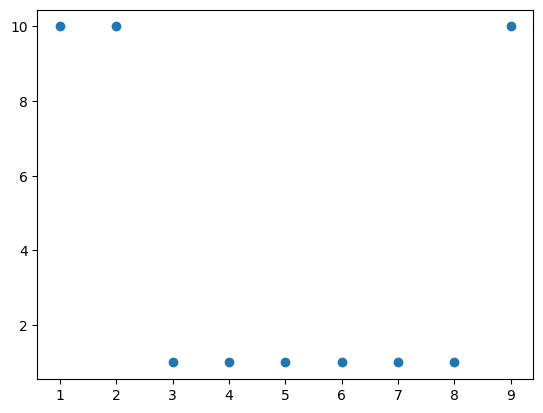

In [ ]:
plt.plot(range(1, 10), [value(model.rv[1, t]) for t in range(1, 10)], 'o')
plt.plot(range(1, 10), [value(model.rv[2, t]) for t in range(1, 10)], 'o')
plt.show()